# 1회차

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

pandas을 사용해 데이터를 불러오겠습니다.

In [2]:
train = pd.read_csv('./train.csv')
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
# train 데이터셋의 행과 열의 수 파악하기
rows = train.shape[0]
columns = train.shape[1]
print('The train dataset contains {0} rows and {1} columns'.format(rows, columns))

The train dataset contains 595212 rows and 59 columns


# 1. Data Quality checks

### Null or missing values check

훈련셋에 결측치가 있는지 파악해보겠습니다.

In [5]:
# any() applied twice to check run the isnull check across all columns
train.isnull().any().any()

False

결측치가 없다고 나오나 실제로 없지 않습니다. 왜냐하면 결측치를 -1로 모두 대체를 했기 때문입니다. 그러므로 데이터가 -1을 나타내면 결측치라고 판단해도 무방합니다. 그렇다면 -1값이 얼마나 있는지 살펴봐야 합니다.

-1 값을 쉽게 알수 있게 NaN값으로 바꾸겠습니다.

In [6]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

그 후 'Missingno' 패키지를 사용하여 편하게 결측치를 시각화할 수 있습니다.

<AxesSubplot:>

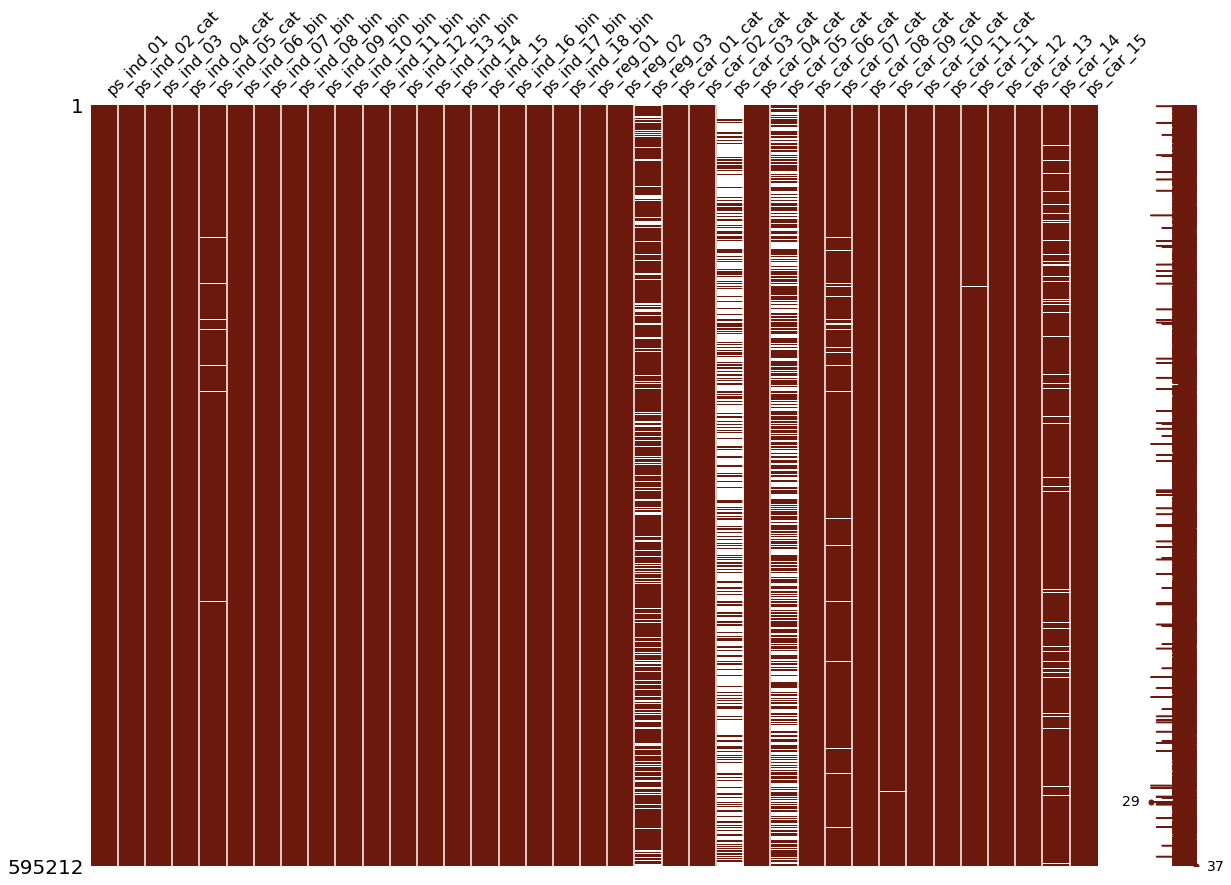

In [7]:
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df=train_copy.iloc[:,2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

그래프를 보면 빈 하얀색 띠(결측치)는 데이터의 결측을 반영합니다. 이 예제에서는 59개의 피처 중 7개의 피처에서 결측이 관찰됩니다. (실제로는 13개의 피처입니다.) 이는 위 결측값 행렬도가 한 그림에 약 40개의 홀수 피처에만 적합할 수 있기 떄문에 나머지 5개의 null 열은 제외되었습니다. 모든 null을 시각화 하려면 그림 크기 인수를 변경하고 데이터 프레임을 조정해야합니다.

우리가 관찰한 7개의 결측치를 포함한 피처입니다.

__ps_ind_05cat/ ps_reg_03/ ps_car_03_cat/ ps_car_05_cat/ ps_car_07_cat/ ps_car_09_cat/ ps_car_14__

결측값은 대부분 _cat 접미사가 붙은 열에서 발생합니다. 그리고 ps_reg_03, ps_car_03_cat 및 ps_car_05_cat 열에는 대부분의 값이 누락되어 있으므로 결측치를 일괄 교체하는 것이 좋은 전략이 아닐 수 있습니다.

### Taget variable inspection

데이터에 대해 일반적으로 수행되는 또 다른 검사는 taget 변수에 대해 수행되며, 이 경우 열의 제목은 'target'입니다. target 값은 class/label/correct 에 의해 발생하며, 이 학습된 함수가 일반화되고 잘 예측할 수 있기를 바라면서 데이터를 목표에 가장 잘 매핑하는 함수를 학습하기 위해 주어진 해당 데이터(이 예제에서는 ID열을 제외한 모든 train 데이터)와 함께 지도 학습 모델에 사용됩니다.

In [8]:
data = [go.Bar(x = train['target'].value_counts().index.values,
              y = train['target'].value_counts().values,
              text = 'Distribution of target variable')]
layout = go.Layout(title='Target variable distribution')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

target 변수가 불균형의 분포를 가지고 있습니다. 이를 유의해야 합니다.

### Datatype check

이번에는 train 셋이 어떤 데이터 유형으로 구성되어 있는지 확인하겠습니다. 즉, 제공된 데이터에 더 나은 개요를 얻기 위해 정수 또는 문자 혹은 실수형인지 확인합니다. 파이썬에서 특정 유형의 개수를 세는 한 가지 요령은 다음과 같이 Collection 모듈을 사용하여 Counter 메서드를 사용하는 것입니다.

In [9]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

위에서 언급한 바와 같이 train 셋을 구성하는 열은 총 59개이며, 피처/열은 정수 및 실수의 두 가지 데이터 유형만으로 구성됩니다.

또 다른 주목할 점은 Porto Seguro가 실제로 '_bin', '_cat', '_reg'와 같이 약어로 된 헤더와 함께 데이터를 제공했다는 것입니다. 여기서 _bin은 이진 피처를 나타내고 나머지는 연속 또는 순서형 피처라는 대략적인 설명을 해주었습니다. 여기서는 실수 값(아마도 연속형만 해당)과 정수 데이터 유형(이항, 범주형 및 순서형 피처)을 살펴봄으로써 이 작업을 좀 더 단순화합니다.

In [10]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

## Correlation plots

먼저 몇 가지 선형 상관 그림을 생성해 피처가 어떻게 다른 피처들과 선형 상관관계가 있는지 간략히 살펴보겠습니다. 

### Correlation of float features

<AxesSubplot:title={'center':'Pearson correlation of continuous features'}>

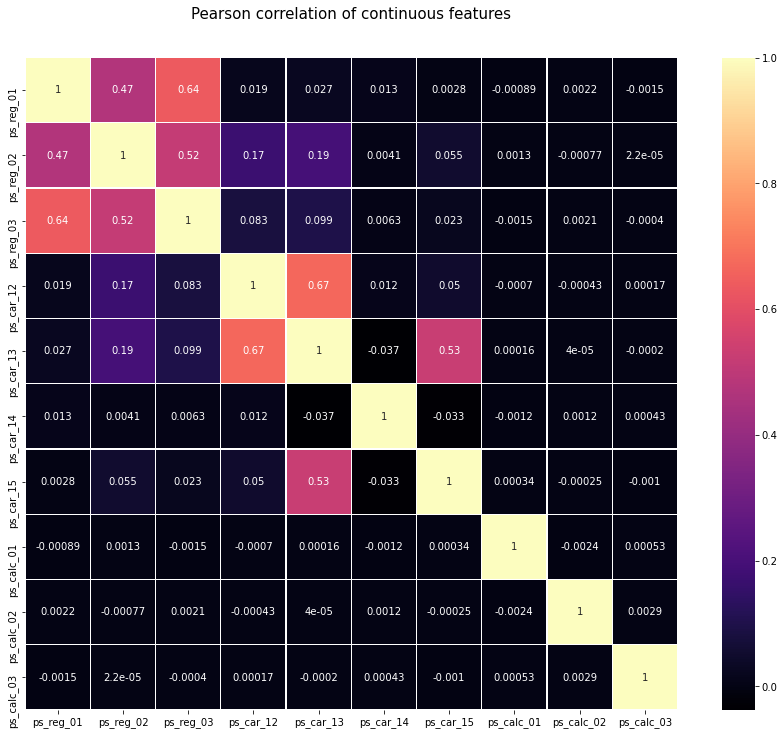

In [11]:
colormap = plt.cm.magma
plt.figure(figsize=(16, 12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

상관관계 그림을 보면, 대다수의 피처들이 서로 거의 0에 가까운 상관관계를 가지고 있음을 알 수 있습니다. 이는 나중에 좀 더 다뤄보겠습니다. 우선 양의 상관관계를 가지는 피처들을 나열하겠습니다.

(ps_reg_01, ps_reg_03)

(ps_reg_02, ps_reg_03)

(ps_car_12, ps_car_13)

(ps_car_13, ps_car_15)

### Correlation of integer features

정수형 데이터 타입을 가진 열에서, plotly 라이브러리를 사용하여 상호작용적으로 히트맵을 생성하겠습니다. 이전의 plotly 플롯과 마찬가지로, 단순히 'go'을 호출함으로써 히트맵을 생성합니다. 여기서는 서로 다른 세 축에 값을 제공해야합니다. x축과 y축은 열 이름을 사용하고, 상관 값은 z축에 제공합니다. 색 척도 속성은 히트맵에서 볼 수 있는 여러 색 팔레트에 해당하는 키워드를 포함합니다. 이 예에서는 Viridis 색 척도를 사용했습니다. (다른 예로는 Portland와 Greys가 있습니다.)

In [31]:
data = [go.Heatmap(z = train_int.corr().values,
                  x = train_int.columns.values,
                  y = train_int.columns.values,
                  colorscale='Viridis',
                  reversescale= False,
                  opacity=1.0)]
layout = go.Layout(title='Pearson Correlation of Integer-type features',
                  xaxis = dict(ticks='', nticks=36),
                  yaxis = dict(ticks=''),
                  width= 900, height=700)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

마찬가지로 서로 전혀 상관 관계가 없는 수 많은 열이 있다는 것을 알 수 있습니다. 주성분 분석(PCA)과 같은 차원 축소 변환을 수행하려는 경우 상당한 상관 관계가 필요합니다.

__음의 상관 관계가 있는 피처__: ps_ind_06_bin, ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin

한 가지 흥미로운 측면은 Nullity에 대한 이전의 분석에서 ps_car_03_cat 및 ps_car_05_cat이 많은 결측치를 포함하는 것으로 확인되었다는 것입니다. 따라서 데이터를 제대로 반영하지 못할 수도 있지만, 두 피처가 강한 양의 상관관계를 가진다는 것은 놀랄 일이 아닙니다.

## Mutual Information plots

Mutual Information은 target 변수와 상응하는 피처의 상호 정보를 검사할 수 있기 때문에 또 다른 유용한 도구입니다. 분류 문제의 경우, 우리는 두 랜덤 변수 사이의 종속성을 측정하는 Sklearn의 mutual_info_classif 방법을 사용할 수 있습니다. 이 방법은 랜덤 변수가 서로 독립적인 경우 0을, 종속일 경우 높은 값을 나타냅니다. 따라서 target 정보가 피처 내에 얼마나 포함될 수 있는지 파악할 수 있습니다.

mutual_info_classif 함수의 sklearn 구현은 'k-nearest neighbours 거리의 엔트로피 추정을 기반으로 하는 비모수 방법에 의존한다'는 것을 알려줍니다.

In [32]:
mf = mutual_info_classif(train_float.values, train.target.values, n_neighbors=3, random_state=17)
print(mf)

[0.01402035 0.00431986 0.0055185  0.00778454 0.00157233 0.00197537
 0.01226    0.00553038 0.00545101 0.00562139]


## Binary features inspection

이번에는 바이너리 값을 가진 열에 대해 살펴보겠습니다. 이항 값이 들어 있는 모든 열을 저장한 다음 다음과 같이 이항 값의 수직 막대 그림을 생성합니다.

In [33]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((train[col]==0).sum())
    one_list.append((train[col]==1).sum())

In [35]:
trace1 = go.Bar(x = bin_col,
               y = zero_list,
               name='Zero count')
trace2 = go.Bar(x = bin_col,
               y = one_list,
               name = 'One count')
data = [trace1, trace2]
layout = go.Layout(barmode='stack',
                  title='Count of 1 and 0 in binary variables')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

위 그림에서 거의 0만 있는 ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin의 4가지 피처가 있음을 알 수 있습니다. 이는 피처가 target에 대한 정보를 많이 포함하고 있지 않기 때문에 유용한지 여부를 판단해야 합니다.

## Feature importance via Random Forest

랜덤 포레스트 분류기로 훈련 데이터를 적합시키고 모델이 교육을 마친 후 피처의 순위를 살펴보는 랜덤 포레스트 모델을 구현하겠습니다. 이것은 유용한 피처 중요성을 얻는 데 파라미터 튜닝이 많이 필요하지 않고, target 불균형을 위해 매우 강력한 앙상블 모델(Bootboot Aggergated 아래 적용된 약한 Decision tree 학습의 앙상블)을 사용하는 빠른 방법입니다.

In [37]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(train.drop(['id', 'target'], axis=1), train.target)
features = train.drop(['id', 'target'], axis=1).columns.values
print("===== training done =====")

===== training done =====


### Plot.ly Scatter plot of feature importance
랜덤 포레스트를 교육한 후에는 'featureimportance' 을 호출하여 피처 중요도 목록을 산점도 그림을 통해 그릴 수 있습니다.

Scatter을 호출하고 x, y축을 정의해야 합니다. marker 속성에서 점들의 크기, 색상 및 스케일을 정의할 수 있습니다.

In [39]:
# Scatter plot
trace = go.Scatter(y = rf.feature_importances_,
                  x = features,
                  mode = 'markers',
                  marker = dict(
                  sizemode = 'diameter',
                  sizeref = 1,
                  size = 13,
                  color = rf.feature_importances_,
                  colorscale = 'Portland',
                  showscale = True),
                  text = features
                  )
data = [trace]

layout = go.Layout(autosize= True,
                  title = 'Random Forest Feature Importance',
                  hovermode= 'closest',
                  xaxis= dict(
                  ticklen = 5,
                  showgrid = False,
                  zeroline = False,
                  showline = False
                  ),
                  yaxis = dict(
                  title = 'Feature Importance',
                  showgrid = False,
                  zeroline = False,
                  ticklen = 5,
                  gridwidth = 2
                  ),
                  showlegend=False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'scatter2010')

추가로 다음과 같은 barplot을 통해 중요도 순으로 순위가 매겨진 모든 피처의 목록을 정렬하여 표시할 수 있습니다.

In [43]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features),
                                    reverse=False)))
trace2 = go.Bar(x=x,
               y=y,
               marker=dict(
               color = x,
               colorscale = 'Viridis',
               reversescale = True
               ),
               name = 'Random Forest Feature Importance',
               orientation='h'
               )
layout = dict(title = 'Barplot of Feature Importances',
             width = 900, height = 2000,
             yaxis = dict(
             showgrid = False,
             showline = False,
             showticklabels = True))
fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

### Decision Tree visualization
또 다른 기법은 모델에 의해 만들어진 tree branch나 결정을 시각화하는 것입니다. 단순성을 위해 의사 결정 트리(max_depth = 3)에 적합했습니다. 3개의 수준만 결정 branch에 표시 되므로, export_graphviz에서 시각화 속성을 내보낸 다음 tree 이미지를 내보내고 가져옵니다.

In [47]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth=3)
decision_tree.fit(train.drop(['id', 'target'], axis=1), train.target)

# Export out trained model as a .dot file
with open('tree1.dot', 'w') as f:
    f = tree.export_graphviz(decision_tree,
                            out_file=f,
                            max_depth=4,
                            impurity=False,  feature_names=train.drop(['id','target'],axis=1).columns.values,
                            class_names = ['No', 'Yes'],
                            rounded=True,
                            filled=True)
    
# Convert .dot to .png to allow display in web notebook
check_call(['dot', '-Tpng', 'tree1.dot', '-o', 'tree1.png'])

# Annotating chart with PIL
img = Image.open('tree1.png')
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage('sample-out.png')

FileNotFoundError: [WinError 2] 지정된 파일을 찾을 수 없습니다

## Feature importance via GBM

이번에는 다른 학습 방법을 통해 피처 중요도를 얻어 보겠습니다. 이번에는 Gradien Boosting 분류기를 사용하여 교육 데이터에 적합하겠습니다.

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, min_samples_leaf=4, max_features=0.2, random_state=0)
gb.fit(train.drop(['id', 'target'], axis=1), train.target)
features = train.drop(['id', 'target'], axis=1).columns.values
print(" ----- training done ------")

 ----- training done ------


In [49]:
# Scatter plot
trace = go.Scatter(y = gb.feature_importances_,
                   x = features,
                   mode='markers',
                   marker = dict(
                   sizemode = 'diameter',
                   sizeref = 1,
                   size = 13,
                   color = gb.feature_importances_,
                   colorscale = 'Portland',
                   showscale = True),
                  text = features)
data = [trace]

layout = go.Layout(autosize=True,
                  title='Gradient Boosting Machine Feature Importance',
                  hovermode='closest',
                  xaxis=dict(
                  ticklen = 5,
                  showgrid = False,
                  zeroline = False,
                  showline = False),
                  yaxis=dict(
                  title = 'Feature Importance',
                  showgrid = False,
                  zeroline = False,
                  ticklen = 5,
                  gridwidth = 2),
                  showlegend = False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

In [50]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_, features), reverse=False)))

trace2 = go.Bar(x=x, y=y,
               marker=dict(
               color = x,
               colorscale = 'Viridis',
               reversescale = True),
               name = 'Gradient Boosting Classifier Feature Importance',
               orientation='h')

layout = dict(title='Barplot of Feature Importances', 
             width = 900, height = 2000,
             yaxis = dict(
             showgrid = False,
             showline = False,
             showticklabels = True))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

흥미롭게도 랜덤 포레스트와 그래디언트 부스트에서 가장 중요한 피처를 ps_car_13으로 꼽았습니다..

# 2회차

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

In [52]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [55]:
test.head(10)

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,...,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,...,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,...,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,...,4,0,0,4,0,1,1,0,0,1
5,5,0,1,6,0,0,1,0,0,0,...,8,1,4,9,1,0,1,0,1,0
6,6,0,1,3,0,0,0,1,0,0,...,2,0,4,6,1,1,0,0,0,0
7,8,0,1,0,0,0,1,0,0,0,...,3,1,4,9,0,1,0,0,0,0
8,10,0,1,7,0,0,0,1,0,0,...,5,1,4,6,0,0,1,0,0,0
9,11,1,1,6,0,0,0,0,0,1,...,6,1,6,10,0,1,1,0,0,0


In [58]:
# train, test 데이터 개수 파악
print(train.shape)
print(test.shape)

(595212, 59)
(892816, 58)


test 셋에는 target 열이 생략됐습니다.

# 1. Data Quality checks

### Null or missing values check

예제 데이터에 -1 값이 결측치를 대체했기 때문에 시각화를 위해 다시 NaN값으로 변환하겠습니다.

In [59]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)
test_copy = test
test_copy = test_copy.replace(-1, np.NaN)

'Missingno' 라이브러리를 활용하여 결측치에 대해 시각화를 해보겠습니다.

<AxesSubplot:>

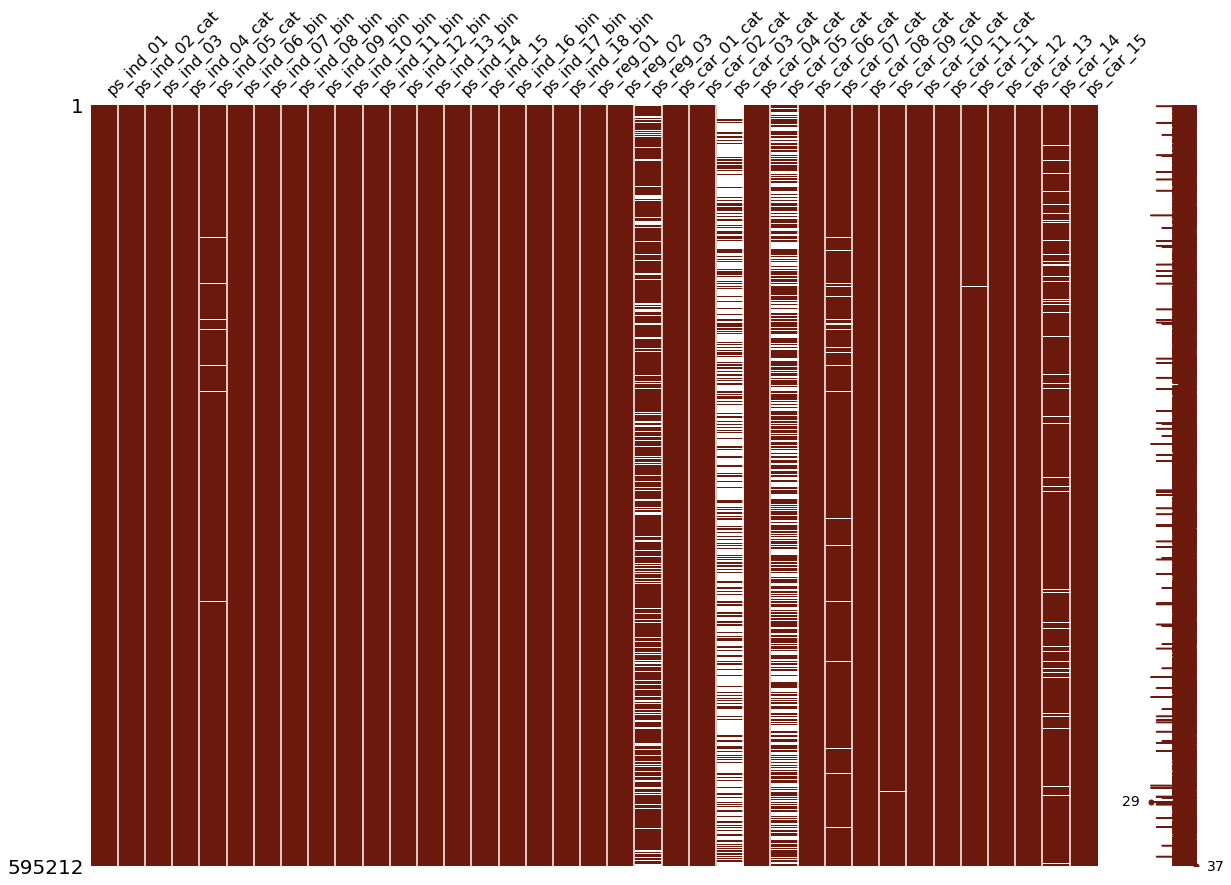

In [61]:
import missingno as msno
msno.matrix(df=train_copy.iloc[:,2:39], figsize=(20, 14), color=(0.42,0.1,0.05))

그래프를 보면 빈 하얀색 띠(결측치)는 데이터의 결측을 반영합니다. 이 예제에서는 59개의 피처 중 7개의 피처에서 결측이 관찰됩니다. (실제로는 13개의 피처입니다.) 이는 위 결측값 행렬도가 한 그림에 약 40개의 홀수 피처에만 적합할 수 있기 떄문에 나머지 5개의 null 열은 제외되었습니다. 모든 null을 시각화 하려면 그림 크기 인수를 변경하고 데이터 프레임을 조정해야합니다.

우리가 관찰한 7개의 결측치를 포함한 피처입니다.

__ps_ind_05cat/ ps_reg_03/ ps_car_03_cat/ ps_car_05_cat/ ps_car_07_cat/ ps_car_09_cat/ ps_car_14__

결측값은 대부분 _cat 접미사가 붙은 열에서 발생합니다. 그리고 ps_reg_03, ps_car_03_cat 및 ps_car_05_cat 열에는 대부분의 값이 누락되어 있으므로 결측치를 일괄 교체하는 것이 좋은 전략이 아닐 수 있습니다.

<AxesSubplot:>

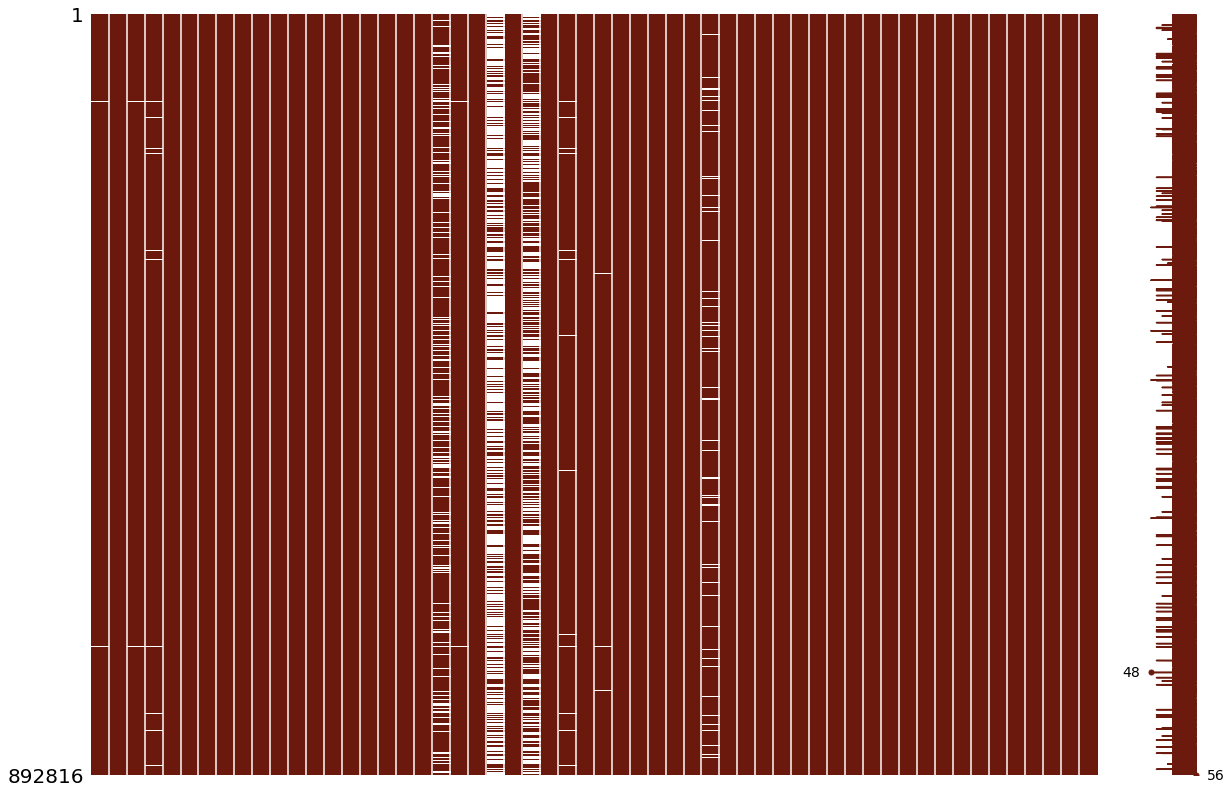

In [62]:
msno.matrix(df=test_copy.iloc[:,2:], figsize=(20, 14), color=(0.42,0.1,0.05))

### Taget variable inspection

데이터에 대해 일반적으로 수행되는 또 다른 검사는 taget 변수에 대해 수행되며, 이 경우 열의 제목은 'target'입니다. target 값은 class/label/correct 에 의해 발생하며, 이 학습된 함수가 일반화되고 잘 예측할 수 있기를 바라면서 데이터를 목표에 가장 잘 매핑하는 함수를 학습하기 위해 주어진 해당 데이터(이 예제에서는 ID열을 제외한 모든 train 데이터)와 함께 지도 학습 모델에 사용됩니다.

In [64]:
data = [go.Bar(x = train['target'].value_counts().index.values,
              y = train['target'].value_counts().values,
              text = 'Distribution of target variable')]
layout = go.Layout(title='Target variable distribution')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

target 변수가 불균형의 분포를 가지고 있습니다. 이를 유의해야 합니다.

### Datatype check

이번에는 train,test 셋이 어떤 데이터 유형으로 구성되어 있는지 확인하겠습니다. 즉, 제공된 데이터에 더 나은 개요를 얻기 위해 정수 또는 문자 혹은 실수형인지 확인합니다. 파이썬에서 특정 유형의 개수를 세는 한 가지 요령은 다음과 같이 Collection 모듈을 사용하여 Counter 메서드를 사용하는 것입니다.

In [69]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

In [70]:
Counter(test.dtypes.values)

Counter({dtype('int64'): 48, dtype('float64'): 10})

위에서 언급한 바와 같이 train 셋을 구성하는 열은 총 59개이며, 피처/열은 정수 및 실수의 두 가지 데이터 유형만으로 구성됩니다. test 셋은 58개 입니다.

또 다른 주목할 점은 Porto Seguro가 실제로 '_bin', '_cat', '_reg'와 같이 약어로 된 헤더와 함께 데이터를 제공했다는 것입니다. 여기서 _bin은 이진 피처를 나타내고 나머지는 연속 또는 순서형 피처라는 대략적인 설명을 해주었습니다. 여기서는 실수 값(아마도 연속형만 해당)과 정수 데이터 유형(이항, 범주형 및 순서형 피처)을 살펴봄으로써 이 작업을 좀 더 단순화합니다.

In [71]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])
test_float = test.select_dtypes(include=['float64'])
test_int = test.select_dtypes(include=['int64'])

## Correlation plots
먼저 몇 가지 선형 상관 그림을 생성해 피처가 어떻게 다른 피처들과 선형 상관관계가 있는지 간략히 살펴보겠습니다.

### Correlation of float features

<AxesSubplot:title={'center':'Pearson correlation of continuous features'}>

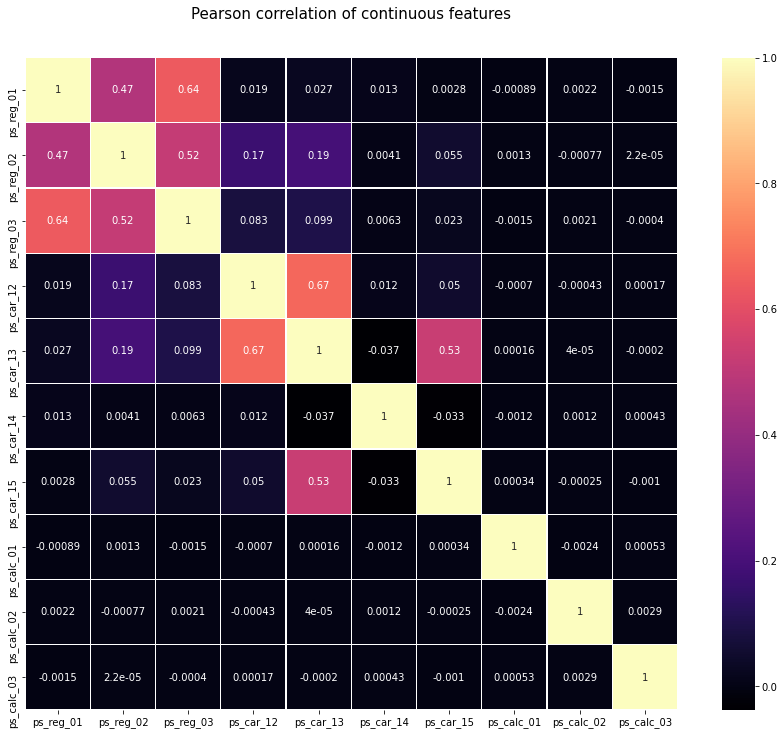

In [72]:
colormap = plt.cm.magma
plt.figure(figsize=(16, 12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1, vmax=1.0, square=True,
           cmap = colormap, linecolor='white', annot=True)

상관관계 그림을 보면, 대다수의 피처들이 서로 거의 0에 가까운 상관관계를 가지고 있음을 알 수 있습니다. 우선 양의 상관관계를 가지는 피처들을 나열하겠습니다.

(ps_reg_01, ps_reg_03)

(ps_reg_02, ps_reg_03)

(ps_car_12, ps_car_13)

(ps_car_13, ps_car_15)

<AxesSubplot:title={'center':'Pearson correlation of continuous features'}>

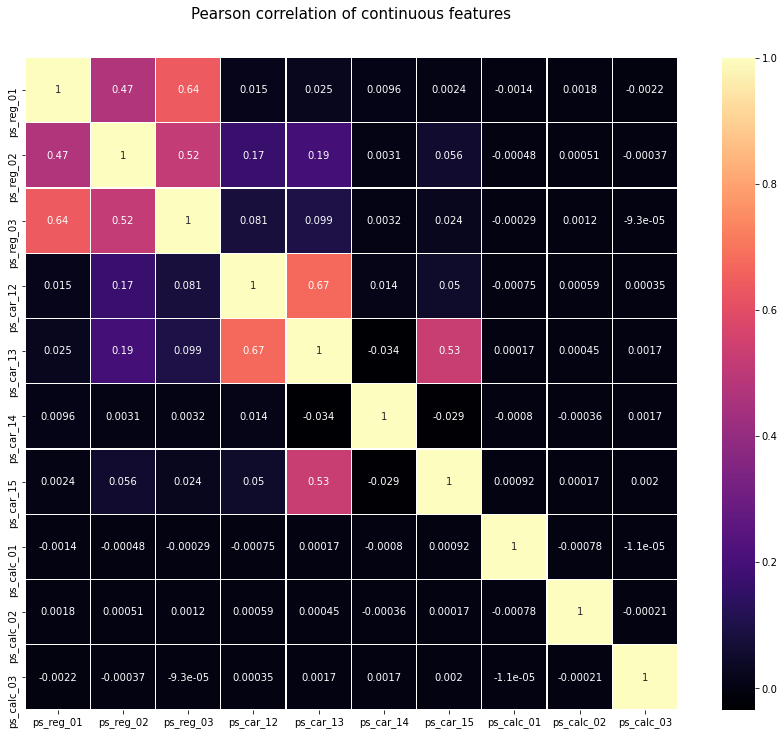

In [74]:
# test set
plt.figure(figsize=(16, 12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(test_float.corr(), linewidths=0.1, vmax=1.0, square=True,
           cmap = colormap, linecolor='white', annot=True)

### Correlation of integer features
정수형 데이터 타입을 가진 열에서, plotly 라이브러리를 사용하여 상호작용적으로 히트맵을 생성하겠습니다. 이전의 plotly 플롯과 마찬가지로, 단순히 'go'을 호출함으로써 히트맵을 생성합니다. 여기서는 서로 다른 세 축에 값을 제공해야합니다. x축과 y축은 열 이름을 사용하고, 상관 값은 z축에 제공합니다. 색 척도 속성은 히트맵에서 볼 수 있는 여러 색 팔레트에 해당하는 키워드를 포함합니다. 이 예에서는 Viridis 색 척도를 사용했습니다. (다른 예로는 Portland와 Greys가 있습니다.)

In [77]:
data = [go.Heatmap(z = train_int.corr().values,
                  x = train_int.columns.values,
                  y = train_int.columns.values,
                  colorscale='Viridis',
                  reversescale=False,
                  opacity=1.0)]

layout = go.Layout(title = 'Pearson Correlation of Integer-type features',
                  xaxis = dict(ticks='', nticks=36),
                  yaxis = dict(ticks=''),
                  width=900, height=700)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

마찬가지로 서로 전혀 상관 관계가 없는 수 많은 열이 있다는 것을 알 수 있습니다. 주성분 분석(PCA)과 같은 차원 축소 변환을 수행하려는 경우 상당한 상관 관계가 필요합니다.

음의 상관 관계가 있는 피처: ps_ind_06_bin, ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin

한 가지 흥미로운 측면은 Nullity에 대한 이전의 분석에서 ps_car_03_cat 및 ps_car_05_cat이 많은 결측치를 포함하는 것으로 확인되었다는 것입니다. 따라서 데이터를 제대로 반영하지 못할 수도 있지만, 두 피처가 강한 양의 상관관계를 가진다는 것은 놀랄 일이 아닙니다.

## Mutual Information plots
Mutual Information은 target 변수와 상응하는 피처의 상호 정보를 검사할 수 있기 때문에 또 다른 유용한 도구입니다. 분류 문제의 경우, 우리는 두 랜덤 변수 사이의 종속성을 측정하는 Sklearn의 mutual_info_classif 방법을 사용할 수 있습니다. 이 방법은 랜덤 변수가 서로 독립적인 경우 0을, 종속일 경우 높은 값을 나타냅니다. 따라서 target 정보가 피처 내에 얼마나 포함될 수 있는지 파악할 수 있습니다.

mutual_info_classif 함수의 sklearn 구현은 'k-nearest neighbours 거리의 엔트로피 추정을 기반으로 하는 비모수 방법에 의존한다'는 것을 알려줍니다.

In [78]:
mf = mutual_info_classif(train_float.values, train.target.values, n_neighbors=3, random_state=17)
print(mf)

[0.01402035 0.00431986 0.0055185  0.00778454 0.00157233 0.00197537
 0.01226    0.00553038 0.00545101 0.00562139]


## Binary features inspection
이번에는 바이너리 값을 가진 열에 대해 살펴보겠습니다. 이항 값이 들어 있는 모든 열을 저장한 다음 다음과 같이 이항 값의 수직 막대 그림을 생성합니다.

In [82]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((train[col]==0).sum())
    one_list.append((train[col]==1).sum())

In [83]:
trace1 = go.Bar(x = bin_col,
               y = zero_list,
               name = 'Zero count')
trace2 = go.Bar(x = bin_col,
               y = one_list,
               name = 'One count')
data = [trace1, trace2]
layout = go.Layout(barmode='stack',
                  title = 'Count of 1 and 0 in binary variables')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Stacked-bar')

위 그림에서 거의 0만 있는 ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin의 4가지 피처가 있음을 알 수 있습니다. 이는 피처가 target에 대한 정보를 많이 포함하고 있지 않기 때문에 유용한지 여부를 판단해야 합니다.

## Feature importance via Random Forest
랜덤 포레스트 분류기로 훈련 데이터를 적합시키고 모델이 교육을 마친 후 피처의 순위를 살펴보는 랜덤 포레스트 모델을 구현하겠습니다. 이것은 유용한 피처 중요성을 얻는 데 파라미터 튜닝이 많이 필요하지 않고, target 불균형을 위해 매우 강력한 앙상블 모델(Bootboot Aggergated 아래 적용된 약한 Decision tree 학습의 앙상블)을 사용하는 빠른 방법입니다.

In [85]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(train.drop(['id', 'target'], axis=1), train.target)
features = train.drop(['id', 'target'], axis=1).columns.values
print('Training Done')

Training Done


## Plot.ly Scatter plot of feature importance
랜덤 포레스트를 교육한 후에는 'featureimportance' 을 호출하여 피처 중요도 목록을 산점도 그림을 통해 그릴 수 있습니다.

Scatter을 호출하고 x, y축을 정의해야 합니다. marker 속성에서 점들의 크기, 색상 및 스케일을 정의할 수 있습니다.

In [90]:
# Scatter plot
trace = go.Scatter(y = rf.feature_importances_,
                  x = features,
                    mode = 'markers',
                  marker = dict(
                  sizemode = 'diameter',
                  sizeref = 1,
                  size = 13,
                  color = rf.feature_importances_,
                  colorscale = 'Portland',
                  showscale = True),
                  text = features)
data = [trace]

layout = go.Layout(autosize = True,
                  title = 'Random Forest Feature Importance',
                  hovermode = 'closest',
                  xaxis=dict(
                  ticklen = 5,
                  showgrid = False,
                  zeroline = False,
                  showline = False),
                  yaxis=dict(
                  title = 'Feature Importance',
                  showgrid = False,
                  zeroline = False,
                  ticklen = 5,
                  gridwidth = 2),
                  showlegend= False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'scatter2010')

추가로 다음과 같은 barplot을 통해 중요도 순으로 순위가 매겨진 모든 피처의 목록을 정렬하여 표시할 수 있습니다.

In [92]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), reverse=False)))
trace2 = go.Bar(x=x,
               y=y,
               marker=dict(
               color=x,
               colorscale = 'Viridis',
               reversescale = True),
               name = 'Random Forest Feature Importance',
               orientation='h')

layout = dict(title = 'Barplot of Feature Importances',
             width=900, height=2000,
             yaxis=dict(
             showgrid = False,
             showline = False,
             showticklabels = True))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')


## Decision Tree visualization
또 다른 기법은 모델에 의해 만들어진 tree branch나 결정을 시각화하는 것입니다. 단순성을 위해 의사 결정 트리(max_depth = 3)에 적합했습니다. 3개의 수준만 결정 branch에 표시 되므로, export_graphviz에서 시각화 속성을 내보낸 다음 tree 이미지를 내보내고 가져옵니다.

In [93]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth=3)
decision_tree.fit(train.drop(['id', 'target'], axis=1), train.target)

# Export out trained model as a .dot file
with open('tree1.dot', 'w') as f:
    f = tree.export_graphviz(decision_tree,
                            out_file=f,
                            max_depth=4,
                            impurity=False,
                            feature_names=train.drop(['id', 'target'], axis=1).columns.values, class_names = ['No', 'Yes'], rounded=True, filled=True)
    
# Convert .dot to .png to allow display in web notebook
check_call(['dot', '-Tpng', 'tree1.dot', '-o', 'tree1.png'])

# Annotating chart with PIL
img = image.open('tree1.png')
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage('sample-out.png')

FileNotFoundError: [WinError 2] 지정된 파일을 찾을 수 없습니다

## Feature importance via GBM
이번에는 다른 학습 방법을 통해 피처 중요도를 얻어 보겠습니다. 이번에는 Gradien Boosting 분류기를 사용하여 교육 데이터에 적합하겠습니다.

In [94]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, min_samples_leaf=4, max_features=0.2, random_state=0)
gb.fit(train.drop(['id', 'target'], axis=1), train.target)
features = train.drop(['id', 'target'], axis=1).columns.values
print('Training Done')

Training Done


In [95]:
# Scatter plot
trace = go.Scatter(y = gb.feature_importances_,
                  x = features,
                    mode = 'markers',
                  marker = dict(
                  sizemode = 'diameter',
                  sizeref = 1,
                  size = 13,
                  color = gb.feature_importances_,
                  colorscale = 'Portland',
                  showscale = True),
                  text = features)
data = [trace]

layout = go.Layout(autosize = True,
                  title = 'Gradient Boosting Machine Feature Importance',
                  hovermode = 'closest',
                  xaxis=dict(
                  ticklen = 5,
                  showgrid = False,
                  zeroline = False,
                  showline = False),
                  yaxis=dict(
                  title = 'Feature Importance',
                  showgrid = False,
                  zeroline = False,
                  ticklen = 5,
                  gridwidth = 2),
                  showlegend= False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'scatter2010')

In [96]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_, features), reverse=False)))

trace2 = go.Bar(x=x, y=y,
               marker=dict(
               color = x,
               colorscale = 'Viridis',
               reversescale = True),
               name = 'Gradient Boosting Classifier Feature Importance',
               orientation='h')

layout = dict(title='Barplot of Feature Importances', 
             width = 900, height = 2000,
             yaxis = dict(
             showgrid = False,
             showline = False,
             showticklabels = True))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

흥미롭게도 랜덤 포레스트와 그래디언트 부스트에서 가장 중요한 피처를 ps_car_13으로 꼽았습니다..

In [115]:
IDtest = test['id']
test_target = pd.Series(gb.predict(test.drop(['id'],axis=1)),name='target')
result = pd.concat([IDtest, test_target], axis=1)
#result = result.iloc[:,1:2]
#result.to_csv('1st commision.csv')

In [109]:
test_target.sum()

43

In [134]:
train

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595207,1488013,0,3,1,10,0,0,0,0,0,...,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,...,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,...,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,...,4,1,4,2,0,1,1,1,0,0
